In [1]:
# Import required packages.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from botocore.client import Config
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import pandas as pd
import numpy as np
import ibm_boto3
import itertools
import types
import math

%matplotlib inline 

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190218011157-0003
KERNEL_ID = 5212cb09-3cdd-4dba-9f8e-4b413242fb82


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Munging and Cleansing  

We'll start by importing the data sets that we'll use:
1. Data set containing data for every city in the U.S. plus average household value between the periods of April, 1996 and December, 2018. 
2. Data set containing zip codes for every metropolitan area in the U.S.  
  
After the data has been imported, we'll start cleaning it, replacing missing values within the data, and tidying the data in accordance to Hadley Wickham's _Tidy Data_ paper (2012, https://vita.had.co.nz/papers/tidy-data.pdf).  
Finally, we'll make sure that each variable within the data is in accordance to it's data type. 

In [2]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e11fb05be7c9453f918a75717a46b2dc = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jmLng0SAo5GXd9hH8-hJnZ0v5oVnB8EW-ICcZvrG4Bmb',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e11fb05be7c9453f918a75717a46b2dc.get_object(Bucket='alonsolab2-donotdelete-pr-j2ailudz9y9jee',Key='Zip_Zhvi_SingleFamilyResidence.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Load the data; encoding changed to ISO-8859-1 to avoid loading errors. 
df_data_1 = pd.read_csv(body, encoding = "ISO-8859-1")
df_data_1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.0,335400.0,336500.0,...,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.0,500900.0,503100.0,...,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.0,77300.0,77300.0,...,120800,121300,122200,123000,123600,124500,125600,126300,126800,127400
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.0,95600.0,95800.0,...,175500,176400,176900,176900,177300,178000,178500,179300,180200,180700


The data was loaded correctly but, we must now first check for any missing variables. We'll test only on the `1996-04` variable since it's the first observation and the most likely to have any missing data. 

In [3]:
na_values = df_data_1.isna().sum()
print(na_values)

RegionID         0
RegionName       0
City             0
State            0
Metro         1403
CountyName       0
SizeRank         0
1996-04       1170
1996-05       1170
1996-06       1170
1996-07       1170
1996-08       1170
1996-09       1170
1996-10       1170
1996-11       1170
1996-12       1170
1997-01       1170
1997-02       1170
1997-03       1170
1997-04       1170
1997-05       1170
1997-06       1170
1997-07       1169
1997-08       1169
1997-09       1169
1997-10       1169
1997-11       1169
1997-12       1169
1998-01       1167
1998-02       1167
              ... 
2016-07          0
2016-08          0
2016-09          0
2016-10          0
2016-11          0
2016-12          0
2017-01          0
2017-02          0
2017-03          0
2017-04          0
2017-05          0
2017-06          0
2017-07          0
2017-08          0
2017-09          0
2017-10          0
2017-11          0
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04     

Between 1996 and, at least, 1998, we have 1,167 missing records. These could be potentially filled by replacing the missing values with the average value for each metropolitan area. However, we also have 1,403 missing metropolitan. Using data obtained from `https://www.dol.gov/owcp/regs/feeschedule/fee/fee11`, we'll try to fill these missing data. 

In [4]:
# Load Metropolitan data 
body = client_e11fb05be7c9453f918a75717a46b2dc.get_object(Bucket='alonsolab2-donotdelete-pr-j2ailudz9y9jee',Key='fs11_gpci_by_msa-zip.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

metro_area = pd.read_csv(body)
metro_area.head()

,ZIP CODE,STATE,MSA No.,GPCI,GPCI.1,GPCI.2,County No.,MSA Name
0,76443.0,TX,10180.0,1.0,0.943,0.936,59.0,Abilene
1,76469.0,TX,10180.0,1.0,0.943,0.936,59.0,Abilene
2,79501.0,TX,10180.0,1.0,0.943,0.936,253.0,Abilene
3,79503.0,TX,10180.0,1.0,0.943,0.936,253.0,Abilene
4,79504.0,TX,10180.0,1.0,0.943,0.936,59.0,Abilene


We'll now take the observations with missing metro name, merge them with the new metro_area dataframe, and paste it back to the original data set. 

In [5]:
# Keep data with missing metro name. 
missing_metro = df_data_1[df_data_1['Metro'].isna()]
missing_index = missing_metro.index

# Drop observation without Metro data. These observations will then be reattached
df_metro_complete = df_data_1.drop(index=missing_index)

# Keep zip code and msa name from the metro_area data set
metro_area_simp = metro_area[['ZIP CODE', 'MSA Name']]

# Merge missing metro with metro_area_simp 
metro_complete = missing_metro.merge(metro_area_simp, how='left', left_on='RegionName', right_on='ZIP CODE')


In [6]:
# Check to see that there are no NaN variables in the new column. 
print(metro_complete['MSA Name'].isna().sum())

# There are no NaN values now. We'll now replace the Metro column with the MSA Name column, drop the overlapping columns, and 
# reattach the observations to the df_data_1 data set. 
metro_complete['Metro'] = metro_complete['MSA Name']
metro_complete1 = metro_complete.iloc[:, 0:280]

# Reattach data to original data. 
df_data_1 = df_metro_complete.append(metro_complete1)
print(df_data_1.shape)

0
(15508, 280)


With the Metro data completed, we'll now replace the remaining NaN observations with the average value per Metropolitan area. 

In [7]:
# Obtain column names of year-month combinations. 
year_month = df_data_1.iloc[:, 7:].columns.values

df_data_2 = df_data_1

# Iterate over year-month combination, replacing NaN with average value for metropolitan area 
for ym in df_data_2[year_month]:
    df_data_2[ym] = df_data_2.groupby('Metro')[ym].transform(lambda x: x.fillna(x.mean()))

In [8]:
df_data_2.describe()

,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
count,15508.000000,15508.000000,1.532400e+04,1.532400e+04,1.532400e+04,1.532400e+04,1.532400e+04,1.532400e+04,1.532400e+04,1.532400e+04,...,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04,1.550800e+04
mean,80789.618326,7754.500000,1.139273e+05,1.140465e+05,1.141640e+05,1.142787e+05,1.144039e+05,1.145477e+05,1.147352e+05,1.149523e+05,...,2.793596e+05,2.806727e+05,2.821487e+05,2.834464e+05,2.844663e+05,2.855002e+05,2.867173e+05,2.880293e+05,2.891875e+05,2.901066e+05
std,31521.484956,4476.918323,8.336502e+04,8.350475e+04,8.364497e+04,8.378947e+04,8.395736e+04,8.416134e+04,8.442109e+04,8.472647e+04,...,3.618684e+05,3.613606e+05,3.631021e+05,3.653018e+05,3.662779e+05,3.670956e+05,3.667725e+05,3.646242e+05,3.611431e+05,3.591327e+05
min,58196.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,1.220000e+04,...,2.170000e+04,2.170000e+04,2.210000e+04,2.220000e+04,2.200000e+04,2.180000e+04,2.170000e+04,2.150000e+04,2.160000e+04,2.190000e+04
25%,67215.000000,3877.750000,6.537538e+04,6.560000e+04,6.570000e+04,6.577500e+04,6.587500e+04,6.610000e+04,6.620000e+04,6.637500e+04,...,1.283000e+05,1.288000e+05,1.296750e+05,1.303000e+05,1.311000e+05,1.319000e+05,1.329000e+05,1.340000e+05,1.351000e+05,1.356000e+05
50%,77886.500000,7754.500000,9.480000e+04,9.493382e+04,9.510000e+04,9.520000e+04,9.530000e+04,9.530000e+04,9.550000e+04,9.560000e+04,...,1.911000e+05,1.921500e+05,1.934000e+05,1.946000e+05,1.957000e+05,1.969000e+05,1.981000e+05,1.996000e+05,2.011000e+05,2.021500e+05
75%,90314.250000,11631.250000,1.378000e+05,1.378000e+05,1.381000e+05,1.381000e+05,1.381000e+05,1.382000e+05,1.386000e+05,1.389250e+05,...,3.107500e+05,3.123000e+05,3.143250e+05,3.161000e+05,3.174250e+05,3.183250e+05,3.198000e+05,3.212000e+05,3.224250e+05,3.239000e+05
max,753844.000000,15508.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,3.888900e+06,...,1.772470e+07,1.740890e+07,1.745050e+07,1.772280e+07,1.800670e+07,1.827380e+07,1.833190e+07,1.813190e+07,1.759490e+07,1.711960e+07


There still appear to be some missing data but it's a much lower number than the original missing data, 184 missing observations in total.  

With the data cleaned, we will continue with our research. The data has region id, region name, city, state, metro, county name, size rank and date as variables. Furthermore, each date has an observation for each zipcode. This is not ideal tidy data, as each observation should be unique. The data will be pivoted to have all the date variables become observations.

In [9]:
# Columns that want to be kept
to_keep = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

# Columns to be converted to observations
to_obs = df_data_2.iloc[:, 7:]

# Pivot the data to have on observation for each region for each year-month. 
df_data_pivot = pd.pivot_table(df_data_2, values=to_obs, columns=to_keep)

# Reset the index and rename year-month and values columns for easy identification.
df_data_pivot = df_data_pivot.reset_index()
df_data_pivot.rename(columns={'level_0':'date', 0:'value'}, inplace=True)

# Convert data column to datetime 
df_data_pivot['date'] = pd.to_datetime(df_data_pivot['date'], infer_datetime_format=True)

# Print first five rows
df_data_pivot.sort_values(['RegionID', 'date']).head()

,date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
0,1996-04-01,58196,1001,Agawam,MA,Springfield,Hampden County,5957,113100.0
15508,1996-05-01,58196,1001,Agawam,MA,Springfield,Hampden County,5957,112800.0
31016,1996-06-01,58196,1001,Agawam,MA,Springfield,Hampden County,5957,112600.0
46524,1996-07-01,58196,1001,Agawam,MA,Springfield,Hampden County,5957,112300.0
62032,1996-08-01,58196,1001,Agawam,MA,Springfield,Hampden County,5957,112100.0


Now that the data has been converted to a tidy data format, we need to check that each variable has the correct data type. The `date` variable is a date time object. The `value` variable should be a float or integer. The remaining variables should all be either objects or strings given that they descriptive data meant to identify each zip code. 

In [10]:
# Check the size of the data. 
print(df_data_pivot.shape)

# Check each columns data type so that there aren't any mismatched types (i.e RegionID should be an object, not o number)
print(df_data_pivot.dtypes)

# RegionID and Region name are identification tags and should therefore be objects. SizeRank is an ordinal value and should also be converted to an object
df_data_pivot['RegionID'] = df_data_pivot['RegionID'].astype(object)
df_data_pivot['RegionName'] = df_data_pivot['RegionName'].astype(object)
df_data_pivot['SizeRank'] = df_data_pivot['SizeRank'].astype(object)

(4233684, 9)
date          datetime64[ns]
RegionID               int64
RegionName             int64
City                  object
State                 object
Metro                 object
CountyName            object
SizeRank               int64
value                float64
dtype: object


### Data Analysis

With each variable correctly assigned to a data type, we'll do some exploratory analysis. First, we should find the range of the data set, meaning what is the maximum and minimum dates. Then, we should know how many states, cities, and regions we are dealing with to gauge a better understanding of the size of the data. Finally, we would like to know the spread of the `value` column and check how this changes over the past 24 observations, both at the national level and state level.  

In [11]:
# Print the first and last date of the data 
print('Oldest observation: ', df_data_pivot['date'].min())
print('Newest observation: ', df_data_pivot['date'].max(), '\n')

# The data spans over 22 years, and has one observation per month. 

# Print the number of unique states, cities, and zipcodes
print('Number of states: ', len(df_data_pivot['State'].unique()))
print('Number of cities: ', len(df_data_pivot['City'].unique()))
print('Number of zipcodes: ', len(df_data_pivot['RegionID'].unique()))

Oldest observation:  1996-04-01 00:00:00
Newest observation:  2018-12-01 00:00:00 

Number of states:  51
Number of cities:  7957
Number of zipcodes:  15508


First thing that immediately pops out is that there are 51 states registered. Let's see if we can find what's going on here. 

In [12]:
# Sort the data by state and print the unique values as an array. 
df_data_pivot.sort_values('State')['State'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

Along with the 50 statet, the data shows the District of Columbia (DC) as a state independent of Virginia (VA).  
With this cleared up, we'll check how the average values change over the past decade at both the national and state levels. We'll also explore which states saw the most change over this same period.

          date      avg_value
152 2008-12-01  224500.705378
153 2009-01-01  223072.205997
154 2009-02-01  221668.480284
155 2009-03-01  220145.702758
156 2009-04-01  218495.801840


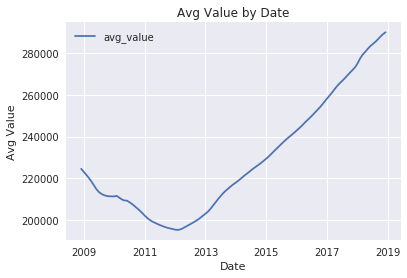

In [13]:
# Create a new data frame to average value per date. Keep observations starting from December 2008 to plot. 
national = df_data_pivot.groupby('date')['value'].mean()
national = national.reset_index()
national.columns = ['date', 'avg_value']
national = national[national['date']>='2008-12-01']
print(national.head())

# Plot the data as a line plot. 
national.plot(x='date', y='avg_value')
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date')
plt.show()

A very interesting pattern appears when we plot the data. The graph begins descending, reaching a trough around 2012, and then it strats growing once again. This could be the effect of the recession that hit the U.S. in 2008, dropping the values of many house markets. We can see however, that around 2012, the market started to recover and has grown at a steady rate.  
How does this look at the state level? 

           date state      avg_value
7752 2008-12-01    AK  280985.714286
7753 2008-12-01    AL  144065.725726
7754 2008-12-01    AR  112872.546247
7755 2008-12-01    AZ  229083.921762
7756 2008-12-01    CA  477386.824583


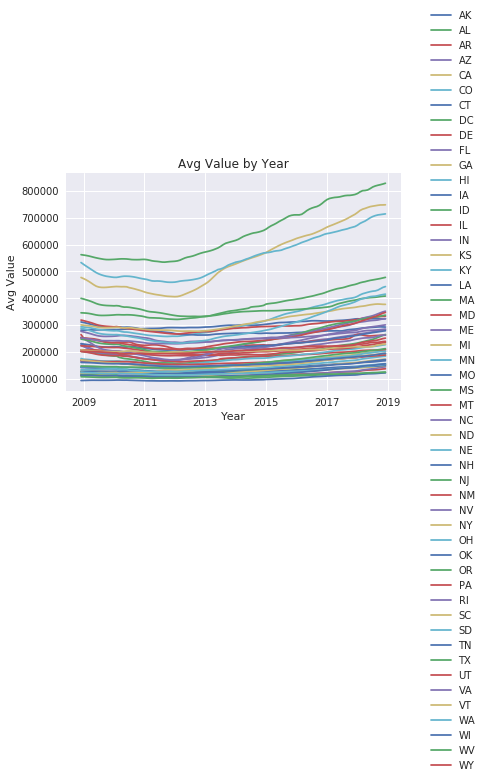

In [14]:
# Create a new data frame starting from December 2008 but looking at values at the state level
state = df_data_pivot.groupby(['date', 'State'])['value'].mean()
state = state.reset_index()
state.columns = ['date', 'state', 'avg_value']
state = state[state['date']>='2008-12-01']
print(state.head())

# Pivot the data frame to produce multiple line plots
state_df = state.pivot(index='date', columns='state', values='avg_value')

# Plot the data
state_df.plot()
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Year')
plt.legend(loc='center right', bbox_to_anchor=[1.25, 0])
plt.show()

Though plagued with a lot of noise at the state level, this graph tells us that there were three states that have recovered more than the remaining 48 states. Unfortunately, the legend is not very helpful as the line colors repeat themselves. However, the top three states have values above 700,000 by December 2018, which allows us to filter the data and identify these states. 

In [15]:
# Retain observations for December 2018. Then filter states with values above 700,000
dec_2018 = state[state['date']=='2018-12-01']
top_three = dec_2018[dec_2018['avg_value']>=700000]

print(top_three[['state', 'avg_value']].sort_values('avg_value', ascending=False))

      state      avg_value
13879    DC  828905.555556
13876    CA  748532.872254
13883    HI  714603.225806


California, the District of Columbia, and Hawaii are the states that didn't do as bad as the rest of the nation and have skyrocketed their values since the recovery from the recession. Any investment efforts should thus be focused their as they're likely to keep their upwards trend.  However, these numbers may be misleading. If we really want to know which market is more likely to see our investment grow at a faster rate, we should see percentage change over the last period. But, percentage change can be noisier on a month to month basis, so we'll calculate percentage change on a year to year basis. 

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


            date state      avg_value  pct_change
8364  2009-12-01    AK  283021.428571    0.007245
8976  2010-12-01    AK  286346.428571    0.011748
9588  2011-12-01    AK  290628.571429    0.014954
10200 2012-12-01    AK  291882.142857    0.004313
10812 2013-12-01    AK  299271.428571    0.025316


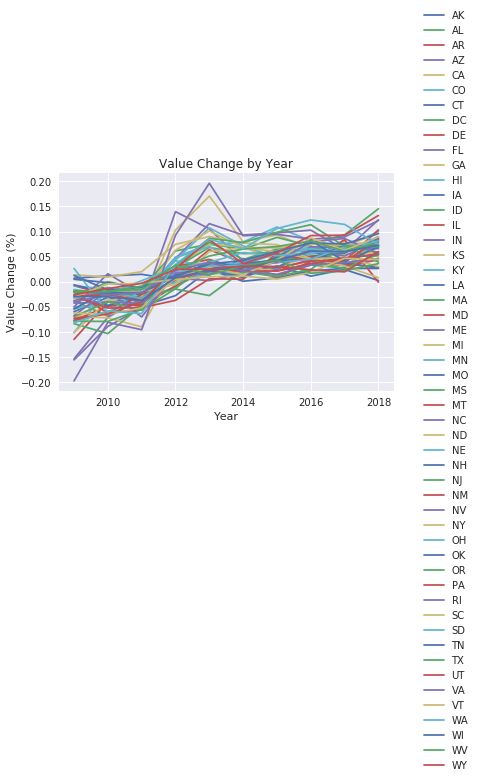

In [16]:
# Identify December observations
dec_obs = state['date'].map(lambda x: x.month) == 12
state_dec = state[dec_obs]

# Calculate value percentage change for each state 
state_dec['pct_change'] = state_dec['avg_value'].div(state_dec.groupby('state')['avg_value'].shift(1))-1
state_dec = state_dec.dropna()
print(state_dec.sort_values(['state', 'date']).head()) 

# Plot the percentage changes for each state. 
state_pct_df = state_dec.pivot(index='date', columns='state', values='pct_change')

# Plot the data
state_pct_df.plot()
_ = plt.xlabel('Year')
_ = plt.ylabel('Value Change (%)')
_ = plt.title('Value Change by Year')
plt.legend(loc='center right', bbox_to_anchor=[1.25, 0])
plt.show()

The graph is noisier but we can see that there are five markets that grew more than 10 percent over the last year. Let's identify these states. 

In [17]:
dec_2018_pct = state_dec[state_dec['date']=='2018-12-01']
pct_10 = dec_2018_pct[dec_2018_pct['pct_change']>0.10]
print(pct_10[['state', 'pct_change']].sort_values('pct_change', ascending=False))

      state  pct_change
13885    ID    0.145236
13916    UT    0.131887
13887    IN    0.123456
13905    NV    0.121917
13898    MT    0.103402


Though the District of Columbia, California, and Hawaii have increased their market value the most, Idaho, Utah, Indiana, Nevada, and Montana have increased their value the most by percentage. Perhaps it would be wiser to invest in these markets than the overpriced ones.  

With this information, we could start answering some questions we might have. For example, how the Arkansas metro area has changed over time and, more specifically, how have the cities of Hot Springs, Little Rock, Fayetteville, and Searcy changed over time. 

In [18]:
# Filter the data, keeping only that for Arkansas and it's metro areo. 
arkansas = df_data_pivot[df_data_pivot['State'] == 'AR']
arkansas.head()

,date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
11359,1996-04-01,89132,71602,White Hall,AR,Pine Bluff,Jefferson County,6454,NaN
11360,1996-04-01,89141,71639,Dumas,AR,AR NONMETROPOLITAN AREA,Desha County,9813,31600.0
11361,1996-04-01,89151,71654,McGehee,AR,AR NONMETROPOLITAN AREA,Desha County,11172,23100.0
11362,1996-04-01,89183,71742,Fordyce,AR,AR NONMETROPOLITAN AREA,Dallas County,10487,46660.0
11363,1996-04-01,89219,71836,Foreman,AR,Texarkana,Little River County,12805,51600.0


There are some NaN observations within the Arkansas data set. Let's do some quick analysis before moving on with the time series. 

In [19]:
# Let's first look at how the data is distributed and how many NaN there are 
print(arkansas.describe())
print(len(arkansas))

# There are 34,398 observations but only 33,889 have data, meaning that there are 509 missing variables. 
# Which data are we missing?

               value
count   33889.000000
mean   101371.376082
std     42571.487169
min     22700.000000
25%     71700.000000
50%     92400.000000
75%    125300.000000
max    330600.000000
34398


In [20]:
# Keep NaN observations
nan_values = arkansas[np.isnan(arkansas['value'])==True]

# Count NaN by Metro
nan_values.groupby('Metro')['Metro'].count()

Metro
Magnolia      167
Pine Bluff    342
Name: Metro, dtype: int64

Not that bad, we're missing data for two metropolitan areas. Let's check to see how many counties are missing data. 

In [21]:
df_data_2[(df_data_2['Metro'] == 'Magnolia') | (df_data_2['Metro'] == 'Pine Bluff')]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
6453,89132,71602,White Hall,AR,Pine Bluff,Jefferson County,6454,NaN,NaN,NaN,...,90600,92300,92600,92600,93300,94000,94800,95400,95700,96100
12206,89399,72132,Redfield,AR,Pine Bluff,Jefferson County,12207,NaN,NaN,NaN,...,110800,113900,116200,117200,118000,119500,121200,122500,123500,124200
13414,89239,71861,Taylor,AR,Magnolia,Columbia County,13415,NaN,NaN,NaN,...,71100,72200,70500,67300,65100,64400,64300,64200,64000,64000


It appears that the missing data will only affect three cities in two counties. We'll omit this observations from the subsequent analysis.  Let's check how Arkansas and, the four cities of Fayetteville, Searcy, Little Rock, and Hot Springs have changed over time. 

In [22]:
# Variation over the last five months. 
print(arkansas.groupby('date')['value'].describe().tail())

            count           mean           std      min       25%       50%  \
date                                                                          
2018-08-01  126.0  133406.349206  50102.366804  39400.0   99850.0  127800.0   
2018-09-01  126.0  134175.396825  50226.190278  40200.0  100725.0  129050.0   
2018-10-01  126.0  135175.396825  50279.297826  41000.0  100975.0  130100.0   
2018-11-01  126.0  136267.460317  50331.659745  41600.0  102475.0  132650.0   
2018-12-01  126.0  137015.079365  50453.733368  41800.0  102950.0  133550.0   

                 75%       max  
date                            
2018-08-01  156275.0  329400.0  
2018-09-01  156850.0  329800.0  
2018-10-01  158025.0  330000.0  
2018-11-01  159175.0  330400.0  
2018-12-01  159900.0  330600.0  


It appears that over the last five months of the data set, the average value of houses in Arkansas has increased steadily. Let's plot the data. 

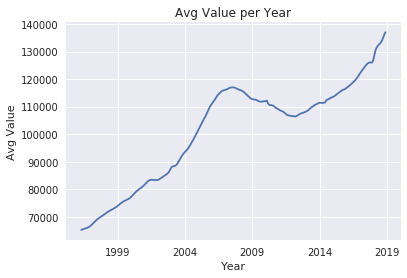

In [23]:
arkansas_avg = arkansas.groupby('date')['value'].mean()
arkansas_avg.plot(x='date', y='value')
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value per Year')
plt.show()

Over the past 20 years, the average value of houses in Arkansas has doubled. However, this increase has not been steady. The value almost doubled in the first ten years. Then, between 2008 and 2012, during the American recession, household values declined. But, the household value has increased at a faster pace in the last five years, recovering healthily from the crisis.  
Now let's check how the four cities mentioned above compare to the rest of Arkansas. 

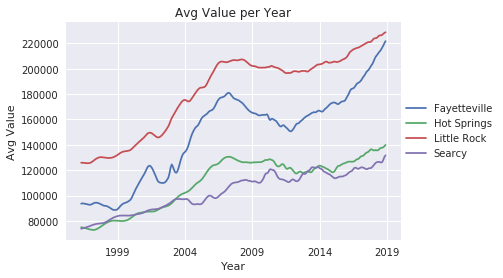

In [24]:
# Keep metro areas of Fayetteville, Hot Springs, Little Rock, Searcy
arkansas_metro = arkansas[(arkansas['City']=='Fayetteville') |
                          (arkansas['City']=='Hot Springs') |
                          (arkansas['City']=='Little Rock') |
                          (arkansas['City']=='Searcy')]

# Calculate average household value of the metro areas and plot
arkansas_metro_avg = arkansas_metro.groupby(['date', 'City'])['value'].mean()
arkansas_metro_avg = arkansas_metro_avg.reset_index()

# Pivot the table
arkansas_metro_avg_pivot = arkansas_metro_avg.pivot(index='date', columns='City', values='value')

# Plot
arkansas_metro_avg_pivot.plot()
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value per Year')
plt.legend(loc='right', bbox_to_anchor=[1.3, 0.5])
plt.show()

The first thing that we notice is that Hot Springs and Searcy have followed the same patter as the rest of Arkansas. Fayettevill and Little Rock, however, have grown at a higher rate than the rest of the state. Nevertheless, we also notice that, of the four cities, only Fayettevill seems to have been affected by the recession; the other cities have seen more stability but not a serious decline.  
Of the four cities, if we were to invest in one of the cities, it would be Little Rock, as it has been the most stable of the four over the past twenty years, even with a recession hitting the nation. 

### Model Building and Testing

Now that we've done some initial analysis of the data and identified some of the states we're interested in investing along with the trendlines, we'll build a forecasting model trying to predict which market will grow the most and thus prove to be our best investment bet. For this, we'll take the data between 1996 and 2017 to be our training data set, while the 2018 data will be used as both our testing and validation set.  
We'll first build our model focusing on three zip codes drawn at random. We'll look at an autocorrelation plot to find the best lag for the model and proceed to parameter tuning. After the initial model has been optimized, we'll build a larger forecaster based on the rest of the data set. 

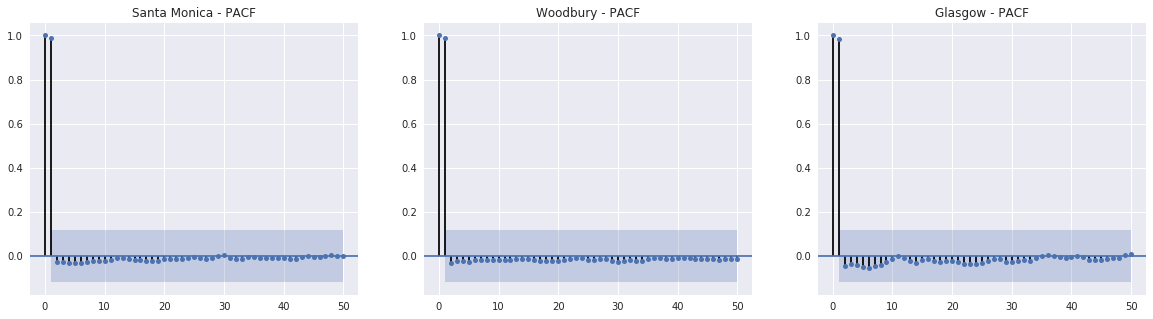

In [25]:
# Select a zip code to represent our data 
santa_monica = df_data_pivot[df_data_pivot['RegionName']==90403]
woodbury = df_data_pivot[df_data_pivot['RegionName']==55125]
glasgow = df_data_pivot[df_data_pivot['RegionName']==59230]

# Set figure size
plt.figure(figsize=(20,5))

# Plot autocorrelation plot for 90403, 55125, and 59230 zip code to identify parameter starting point for ARIMA model
ax1 = plt.subplot(131)
plot_pacf(santa_monica.value, lags=50, ax=ax1)
_ = plt.title('Santa Monica - PACF')

ax2 = plt.subplot(132)
plot_pacf(woodbury.value, lags=50, ax=ax2)
_ = plt.title('Woodbury - PACF')

ax3 = plt.subplot(133)
plot_pacf(glasgow.value, lags=50, ax=ax3)
_ = plt.title('Glasgow - PACF')

plt.show()

For the three zip codes we've chosen, we can see that the partial autocorrelation is one. We'll use this value as a starting point for the ARIMA model.  
The model will first be built using the `santa_monica` data set, which will be transformed to keep the `value` variable as the only column, while the `date` variable will be turned into the index. Then, we'll split the data into a training set containing all data between 1996 and 2017; the testing set will consist of data from 2018.  

In [26]:
# Transforming the Santa Monica subset 
santa_monica_simp = santa_monica[['date', 'value']]
santa_monica_simp = santa_monica_simp.set_index('date')

# Separate into training and test sets
sm_train = santa_monica_simp.loc[:'2017-12-01']
sm_test = santa_monica_simp.loc['2018-01-01':]

With the train and test sets ready, we'll start with initial parameter tuning to find the optimized model on which to build the forecast. 

In [27]:
# Define the p, d and q parameters to take any value between 1 and 10
p = range(1, 5)
d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 0, 1) x (1, 0, 1, 12)
SARIMAX: (1, 0, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (2, 0, 0, 12)


In [ ]:
# Initiate list to store parameter conditions
aic_results = []

# Loop over parameter combinations and store them in list. 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sm_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            output = np.array([param, param_seasonal, results.aic])
            aic_results.append(output)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [40]:
# Convert aic_result list to dataframe and print lowest aic
aic_results_df = pd.DataFrame(np.array(aic_results).reshape(-1,3))
aic_results_df.columns = ['pdq', 'seasonal_pdq', 'aic']

# Print lowest AIC
aic_results_df.sort_values('aic').iloc[0]

# Lowest AIC is 3871.8; we'll use these parameters to build the model. 

pdq                 (4, 1, 0)
seasonal_pdq    (4, 1, 0, 12)
aic                    3871.8
Name: 238, dtype: object

In [29]:
# Build the ARIMA model
#model = ARIMA(sm_train.value, order=(5,1,0))
#model_fit = model.fit(disp=0)
#print(model_fit.summary())


#history = [x for x in sm_train]
#predictions = list()
#for t in range(len(sm_test)):
#    model = ARIMA(sm_train, order=(5,1,0))
#    model_fit = model.fit(disp=0)
#    output = model_fit.forecast()
#    yhat = output[0]
#    predictions.append(yhat)
#    obs = sm_test[t]
#    history.append(obs)
#    print('predicted=%f, expected=%f' % (yhat, obs))
#error = mean_squared_error(sm_test, predictions)
#print('Test MSE: %.3f' % error)
## plot
#pyplot.plot(sm_test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

3. Develop model to forecast 2018 average median household value by zip code. Use 1997 - 2017 as training data. 
4. Focus model results in eight states (CA, DC, HI, ID, IN, MT, NV, UT)
5. Top three investment opportunities in these eight states.

### Resources
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3